In [6]:
import sys
sys.path.insert(1, r'C:\Users\Donald\PycharmProjects\monkey_nuc_segment\stardist\monkey')
from scoring_for_donald import TileSetScorer, ScoringSubroutine

In [7]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
import json
matplotlib.rcParams["image.interpolation"] = 'nearest'
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
from glob import glob
from tqdm import tqdm
from tifffile import imread
import struct
import pandas as pd
import cv2
from csbdeep.utils import Path, normalize
from glob import glob

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [8]:
def load_model(model_path: str) -> StarDist2D:
    # Load StarDist model weights, configurations, and thresholds
    with open(model_path + '\\config.json', 'r') as f:
        config = json.load(f)
    with open(model_path + '\\thresholds.json', 'r') as f:
        thresh = json.load(f)
    model = StarDist2D(config=Config2D(**config), basedir=model_path, name='offshoot_model')
    model.thresholds = thresh
    print('Overriding defaults:', model.thresholds, '\n')
    model.load_weights(model_path + '\\weights_best.h5')
    return model

In [9]:
model_pths = r'\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models'
pths = os.listdir(model_pths)
pths = ["".join([model_pths, '\\', pth]) for pth in pths if 'monkey' in pth]

In [10]:
for pth in pths:
    print(pth)

\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_10_gaus_ratio_0
\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_10_gaus_ratio_0.1
\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_20_gaus_ratio_0
\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_20_gaus_ratio_0.1
\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_30_gaus_ratio_0
\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_30_gaus_ratio_0.1
\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_40_gaus_ratio_0
\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_40_gaus_ratio_0.1
\\10.99.

In [11]:
models = [load_model(pth) for pth in pths]

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.7193147122688542, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.7175685959330165, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.7096244997901542, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.5993075455383543, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.6465368267180926, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.6272559838417484, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.6423720004434031, nms=0.3) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Overriding defaults: Thresholds(prob=0.6029333830621246, nms=0.3) 

Using default va

In [12]:
# load tile images and masks
pthHE = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\tiles'
pthmasks = r'\\10.99.68.178\andreex\data\Stardist\Testing\monkey\qupath\ground_truth\masks'

HE_tiles_pths = sorted(glob(os.path.join(pthHE,'*.tif')))
mask_tiles_pths = sorted(glob(os.path.join(pthmasks,'*.tif')))

HE_tiles = list(map(imread,HE_tiles_pths))
mask_tiles = list(map(imread,mask_tiles_pths))

HE_tiles_default = [normalize(x) for x in HE_tiles]  # just divide by 255 to get into (0,1) range
mask_tiles_default = [fill_label_holes(y) for y in mask_tiles]  # fills holes in annotations if there are any

HE_tiles = [x/255 for x in HE_tiles]  # just divide by 255 to get into (0,1) range
mask_tiles = [fill_label_holes(y) for y in mask_tiles]  # fills holes in annotations if there are any

In [13]:
def get_predictions(model):
    mask_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(HE_tiles)]

    return mask_val_pred

In [14]:
def get_f1(tp, fp, fn):
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    avg_precision = tp / (tp + fp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, avg_precision, f1

In [15]:
def find_first_unique_indices(lst):
    unique_indices = {}
    result = []

    for i, value in enumerate(lst):
        if value not in unique_indices:
            unique_indices[value] = i

    for value in lst:
        result.append(unique_indices[value])

    return result

In [16]:
def get_organ_f1(result):
    names = result['Image']

    names = [name.split(".")[0][21:] for name in names]

    for i in range(len(names)):
        #if len(names[i]) > 6:
        names[i] = names[i][:2]

    result_list = find_first_unique_indices(names)

    f1_scores = result['F1 Score']

    seen = []
    names = []

    raw_vals = result[['Image', 'TP', 'FP', 'FN', 'Avg Precision']]

    TPs = [0 for _ in range(len(raw_vals))]
    FPs = [0 for _ in range(len(raw_vals))]
    FNs = [0 for _ in range(len(raw_vals))]
    APs = [0 for _ in range(len(raw_vals))]

    for i in range(len(raw_vals)):
        row = raw_vals.iloc[i]
        num = result_list[i]
        if num not in seen:
            names.append(raw_vals['Image'][i])
            seen.append(num)

        TPs[num] += row['TP']
        FPs[num] += row['FP']
        FNs[num] += row['FN']
        APs[num] += row['Avg Precision']

    organ_names = []
    for i in range(len(names)):
        nm = names[i][21:-4]
        if nm[-1] == '1':
            nm = nm[:-1]
        organ_names.append(nm)

    TPs = [val for val in TPs if val != 0]
    FPs = [val for val in FPs if val != 0]
    FNs = [val for val in FNs if val != 0]
    APs = [val for val in APs if val != 0]

    if [len(organ_names), len(TPs), len(FPs), len(FNs)] != [len(organ_names), len(organ_names), len(organ_names), len(organ_names)]:
        print('skipped')
        return 0

    new_df = pd.DataFrame({'Organ': organ_names, 'TP': TPs, 'FP': FPs, 'FN': FNs, 'AP': APs})

    precisions = []
    recalls = []
    f1s = []
    APs = []

    for i in range(len(new_df)):
        row = new_df.iloc[i]

        tp = row['TP']
        fp = row['FP']
        fn = row['FN']

        precision, recall, avg_precision, f1 = get_f1(tp, fp, fn)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        APs.append(avg_precision)

    new_df['Recall'] = recalls
    new_df['Precision'] = precisions
    new_df['F1'] = f1s
    new_df['AP'] = APs

    return new_df

In [17]:
# variables for plotting and stuff
nms = [os.path.basename(file) for file in HE_tiles_pths]

taus = [0.5, 0.6, 0.7, 0.8, 0.9]

predictions = [get_predictions(model) for model in models]

scores = []

for tau in taus:
    print(tau)
    scores_tau = []
    for model_prediction in predictions:
        score = TileSetScorer(nms, mask_tiles, model_prediction, [tau])
        scores_tau.append(score)
    scores.append(scores_tau)

100%|██████████| 36/36 [00:05<00:00,  6.77it/s]
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


0.5


scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty 

0.6


scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty 

0.7


scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty 

0.8


scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty 

0.9


scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty 

In [18]:
results = []
for score_list in scores:
    result_dfs = []
    for score in score_list:
        result_dfs.append(score.score_set())
    results.append(result_dfs)

scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
scoring_for_donald.py (62): The behavior of DataFrame concatenation with empty 

In [19]:
results[0][3].head()

,Image,Tau,IoU,TP,FP,FN,Precision,Recall,Avg Precision,F1 Score,Seg Quality,Pan Quality
0,monkey_fetus_40_0272_eyes1.tif,0.5,0.749690,169,16,29,0.913514,0.853535,0.789720,0.882507,0.820991,0.724530
1,monkey_fetus_40_0273_bone.tif,0.5,0.721479,36,6,20,0.857143,0.642857,0.580645,0.734694,0.821069,0.603234
2,monkey_fetus_40_0281_eyes2.tif,0.5,0.688144,170,17,71,0.909091,0.705394,0.658915,0.794393,0.767257,0.609503
3,monkey_fetus_40_0308_liver1.tif,0.5,0.823688,148,7,7,0.954839,0.954839,0.913580,0.954839,0.848706,0.810378
4,monkey_fetus_40_0323_ears1.tif,0.5,0.671899,175,50,57,0.777778,0.754310,0.620567,0.765864,0.717776,0.549719


In [20]:
results[1][3].head()

,Image,Tau,IoU,TP,FP,FN,Precision,Recall,Avg Precision,F1 Score,Seg Quality,Pan Quality
0,monkey_fetus_40_0272_eyes1.tif,0.6,0.749690,163,22,35,0.881081,0.823232,0.740909,0.851175,0.831102,0.707413
1,monkey_fetus_40_0273_bone.tif,0.6,0.721479,35,7,21,0.833333,0.625000,0.555556,0.714286,0.828240,0.591600
2,monkey_fetus_40_0281_eyes2.tif,0.6,0.688144,156,31,85,0.834225,0.647303,0.573529,0.728972,0.786125,0.573063
3,monkey_fetus_40_0308_liver1.tif,0.6,0.823688,148,7,7,0.954839,0.954839,0.913580,0.954839,0.848706,0.810378
4,monkey_fetus_40_0323_ears1.tif,0.6,0.671899,148,77,84,0.657778,0.637931,0.478964,0.647702,0.747148,0.483930


In [21]:
results[2][3].head()

,Image,Tau,IoU,TP,FP,FN,Precision,Recall,Avg Precision,F1 Score,Seg Quality,Pan Quality
0,monkey_fetus_40_0272_eyes1.tif,0.7,0.749690,156,29,42,0.843243,0.787879,0.687225,0.814621,0.840302,0.684528
1,monkey_fetus_40_0273_bone.tif,0.7,0.721479,32,10,24,0.761905,0.571429,0.484848,0.653061,0.843273,0.550709
2,monkey_fetus_40_0281_eyes2.tif,0.7,0.688144,125,62,116,0.668449,0.518672,0.412541,0.584112,0.818401,0.478038
3,monkey_fetus_40_0308_liver1.tif,0.7,0.823688,141,14,14,0.909677,0.909677,0.834320,0.909677,0.858652,0.781096
4,monkey_fetus_40_0323_ears1.tif,0.7,0.671899,105,120,127,0.466667,0.452586,0.298295,0.459519,0.784799,0.360630


In [24]:
len(results[0])

96

In [34]:
results[4][0]

,Image,Tau,IoU,TP,FP,FN,Precision,Recall,Avg Precision,F1 Score,Seg Quality,Pan Quality
0,monkey_fetus_40_0272_eyes1.tif,0.9,0.739823,35,146,163,0.193370,0.176768,0.101744,0.184697,0.919438,0.169817
1,monkey_fetus_40_0273_bone.tif,0.9,0.729419,6,31,50,0.162162,0.107143,0.068966,0.129032,0.922637,0.119050
2,monkey_fetus_40_0281_eyes2.tif,0.9,0.682934,10,170,231,0.055556,0.041494,0.024331,0.047506,0.916975,0.043562
3,monkey_fetus_40_0308_liver1.tif,0.9,0.807160,39,109,116,0.263514,0.251613,0.147727,0.257426,0.919262,0.236642
4,monkey_fetus_40_0323_ears1.tif,0.9,0.670261,3,215,229,0.013761,0.012931,0.006711,0.013333,0.917293,0.012231
5,monkey_fetus_40_0344_brain1.tif,0.9,0.763148,39,197,244,0.165254,0.137809,0.081250,0.150289,0.924578,0.138954
6,monkey_fetus_40_0380_heart1.tif,0.9,0.758650,13,70,78,0.156627,0.142857,0.080745,0.149425,0.914230,0.136609
7,monkey_fetus_40_0381_thymus.tif,0.9,0.810057,27,118,142,0.186207,0.159763,0.094077,0.171975,0.918074,0.157885
8,monkey_fetus_40_0426_lungs.tif,0.9,0.692953,8,170,253,0.044944,0.030651,0.018561,0.036446,0.914221,0.033320
9,monkey_fetus_40_0428_thyroid1.tif,0.9,0.748314,22,89,100,0.198198,0.180328,0.104265,0.188841,0.919661,0.173670


In [44]:
dfs = []
for j, score_list in enumerate(results):
    df_list = []
    for i, df in enumerate(score_list):
        new_df = get_organ_f1(df)
        if type(new_df) != int:
            new_df['Tau'] = df['Tau']
            df_list.append(new_df)
        else:
            df_list.append(0)
            print(f'Skipped: {j} {i}')
    dfs.append(df_list)

skipped
Skipped: 1 73
skipped
Skipped: 1 74
skipped
Skipped: 1 76
skipped
Skipped: 1 86
skipped
Skipped: 1 87
skipped
Skipped: 1 89
skipped
Skipped: 1 90
skipped
Skipped: 1 91
skipped
Skipped: 1 95
skipped
Skipped: 2 73
skipped
Skipped: 2 74
skipped
Skipped: 2 75
skipped
Skipped: 2 76
skipped
Skipped: 2 79
skipped
Skipped: 2 86
skipped
Skipped: 2 87
skipped
Skipped: 2 89
skipped
Skipped: 2 90
skipped
Skipped: 2 91
skipped
Skipped: 2 93
skipped
Skipped: 2 95
skipped
Skipped: 3 73
skipped
Skipped: 3 74
skipped
Skipped: 3 75
skipped
Skipped: 3 76
skipped
Skipped: 3 79
skipped
Skipped: 3 86
skipped
Skipped: 3 87
skipped
Skipped: 3 89
skipped
Skipped: 3 90
skipped
Skipped: 3 91
skipped
Skipped: 3 93
skipped
Skipped: 3 95
skipped
Skipped: 4 73
skipped
Skipped: 4 74
skipped
Skipped: 4 75
skipped
Skipped: 4 76
skipped
Skipped: 4 77
skipped
Skipped: 4 79
skipped
Skipped: 4 81
skipped
Skipped: 4 85
skipped
Skipped: 4 86
skipped
Skipped: 4 87
skipped
Skipped: 4 89
skipped
Skipped: 4 90
skipped
Sk

In [45]:
print(len(dfs[0]))
print(len(dfs[1]))
print(len(dfs[2]))
print(len(dfs[3]))
print(len(dfs[4]))

96
96
96
96
96


In [46]:
dfs_t = list(map(list, zip(*dfs))) # transpose list

In [47]:
dfs_t[0][3].head()

,Organ,TP,FP,FN,AP,Recall,Precision,F1,Tau
0,eyes,198,163,241,0.328904,0.451025,0.548476,0.495000,0.8
1,bone,70,56,96,0.315315,0.421687,0.555556,0.479452,0.8
2,liver,195,115,177,0.400411,0.524194,0.629032,0.571848,0.8
3,ears,92,228,288,0.151316,0.242105,0.287500,0.262857,0.8
4,brain,476,459,645,0.301266,0.424621,0.509091,0.463035,0.8


In [48]:
dfs_t[1][3].head()

,Organ,TP,FP,FN,AP,Recall,Precision,F1,Tau
0,eyes,194,163,245,0.322259,0.441913,0.543417,0.487437,0.8
1,bone,70,55,96,0.316742,0.421687,0.560000,0.481100,0.8
2,liver,183,134,189,0.361660,0.491935,0.577287,0.531205,0.8
3,ears,91,242,289,0.146302,0.239474,0.273273,0.255259,0.8
4,brain,470,494,651,0.291022,0.419269,0.487552,0.450839,0.8


In [49]:
dfs_t[2][3].head()

,Organ,TP,FP,FN,AP,Recall,Precision,F1,Tau
0,eyes,199,159,240,0.332776,0.453303,0.555866,0.499373,0.8
1,bone,67,57,99,0.300448,0.403614,0.540323,0.462069,0.8
2,liver,184,124,188,0.370968,0.494624,0.597403,0.541176,0.8
3,ears,74,256,306,0.116352,0.194737,0.224242,0.208451,0.8
4,brain,482,476,639,0.301816,0.429973,0.503132,0.463684,0.8


In [51]:
for i, df_list in enumerate(dfs_t):
    for df in df_list:
        if type(df) != int:
            df['pth_model'] = os.path.basename(pths[i])

In [52]:
dfs_t[2][3].head()

,Organ,TP,FP,FN,AP,Recall,Precision,F1,Tau,pth_model
0,eyes,199,159,240,0.332776,0.453303,0.555866,0.499373,0.8,monkey_12_12_2023_lr_0.0005_epochs_100_pt_20_g...
1,bone,67,57,99,0.300448,0.403614,0.540323,0.462069,0.8,monkey_12_12_2023_lr_0.0005_epochs_100_pt_20_g...
2,liver,184,124,188,0.370968,0.494624,0.597403,0.541176,0.8,monkey_12_12_2023_lr_0.0005_epochs_100_pt_20_g...
3,ears,74,256,306,0.116352,0.194737,0.224242,0.208451,0.8,monkey_12_12_2023_lr_0.0005_epochs_100_pt_20_g...
4,brain,482,476,639,0.301816,0.429973,0.503132,0.463684,0.8,monkey_12_12_2023_lr_0.0005_epochs_100_pt_20_g...


In [54]:
import pickle

file_path = r'\\10.99.68.178\andreex\data\Stardist\hyperparameter_testing_12_13_data\results_FINAL.pkl'

file_path = r'C:\Users\Donald\results_hyperparameter_testing.pkl'

if not os.path.exists(file_path):

    # Pickle the DataFrame
    with open(file_path, 'wb') as file:
        pickle.dump(dfs_t, file)

    print(f'DataFrame has been pickled and saved to {file_path}')

DataFrame has been pickled and saved to C:\Users\Donald\results_hyperparameter_testing.pkl


In [55]:
len(dfs)

5

In [56]:
def mean_avg_precision(df):    
    MAP = 0

    for i in range(len(df)):
        row = df.iloc[i]

        MAP += row['AP']

    MAP = MAP/len(df)

    return MAP

In [81]:
model_mAPs = []
for df_list in dfs_t:
    mAPs = []
    for df in df_list:
        if type(df) != int:
            # print(df.iloc[0]['Tau'])
            #df.head()
            mAP = mean_avg_precision(df)
            # print(mAP)
            mAPs.append(mAP)
        else:
            mAPs.append(0)
    model_mAPs.append(mAPs)

In [82]:
model_mAPs[0]

[0.6497455474443673,
 0.5766752438649796,
 0.4533550150533056,
 0.27279020411182797,
 0.04932570569300726]

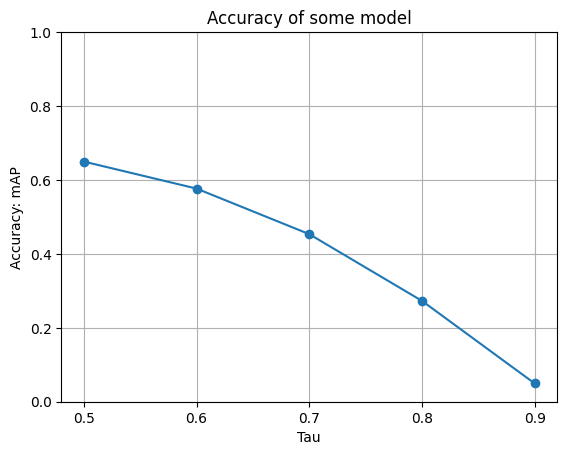

In [83]:
plt.plot(taus, model_mAPs[0], marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Tau')
plt.ylabel('Accuracy: mAP')
plt.title('Accuracy of some model')
plt.xticks(taus)
plt.ylim(0, 1)
plt.grid('on')

# Display the plot
plt.show()

In [80]:
mAPs

[0.007738266393916934,
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0]]

In [84]:
import numpy as np
from scipy import integrate

aucs = []
means=[]

for i, mAPs in enumerate(model_mAPs):
    print(pths[i])
    if mAPs != 0:
        area_under_curve = integrate.trapz(mAPs, taus)
        mean = np.mean(mAPs)
    else:
        area_under_curve = 0
        mean = 0
    print(f"Area under the curve: {area_under_curve}")
    aucs.append(area_under_curve)
    print(f'Mean value on curve: {mean}\n')
    means.append(mean)

\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_10_gaus_ratio_0
Area under the curve: 0.16523560895988007
Mean value on curve: 0.40037834323349764

\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_10_gaus_ratio_0.1
Area under the curve: 0.1629429119938852
Mean value on curve: 0.39381483025265196

\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_20_gaus_ratio_0
Area under the curve: 0.16162515391789242
Mean value on curve: 0.39113212671129605

\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_20_gaus_ratio_0.1
Area under the curve: 0.16219975087890953
Mean value on curve: 0.3927107086411793

\\10.99.68.178\andreex\data\Stardist\12_12_hyperparameter_models\monkey_12_12_2023_lr_0.0005_epochs_100_pt_30_gaus_ratio_0
Area under the curve: 0.1624879708231852
Mean v

In [85]:
means

[0.40037834323349764,
 0.39381483025265196,
 0.39113212671129605,
 0.3927107086411793,
 0.39366746507374706,
 0.39093183679651433,
 0.38548581921410185,
 0.3671995719790507,
 0.3996241489098248,
 0.3995363846115184,
 0.3882349746526558,
 0.387566707427248,
 0.37924517961348897,
 0.3764615022170199,
 0.39185830965430946,
 0.39120264947913086,
 0.38291865733890573,
 0.3660491963340501,
 0.391238152119464,
 0.3872537236098663,
 0.36306177572956083,
 0.3739806763624898,
 0.38827924028155547,
 0.3673021968530255,
 0.4062890570772468,
 0.3839387404314357,
 0.3903395391224147,
 0.3848440890657262,
 0.4018676694487997,
 0.38039512960053773,
 0.39374565082375274,
 0.3924886446663874,
 0.4011248664989804,
 0.38224087523968087,
 0.40522291203064925,
 0.3831953090931294,
 0.3741992211931532,
 0.38333909320513376,
 0.3834182930380088,
 0.401857283320349,
 0.4086957159539037,
 0.3852276320756518,
 0.39534874280523213,
 0.3826472300195142,
 0.3911122764637446,
 0.3930849009337948,
 0.3866675981495356

In [90]:
ind = np.argmax(means)
print(ind)
print(means[ind])

40
0.4086957159539037


In [92]:
ind = np.argmax(aucs)
print(ind)
print(aucs[ind])

40
0.1692198365642436


In [93]:
pths[ind]

'\\\\10.99.68.178\\andreex\\data\\Stardist\\12_12_hyperparameter_models\\monkey_12_12_2023_lr_0.001_epochs_400_pt_10_gaus_ratio_0'

In [86]:
len(means)

96

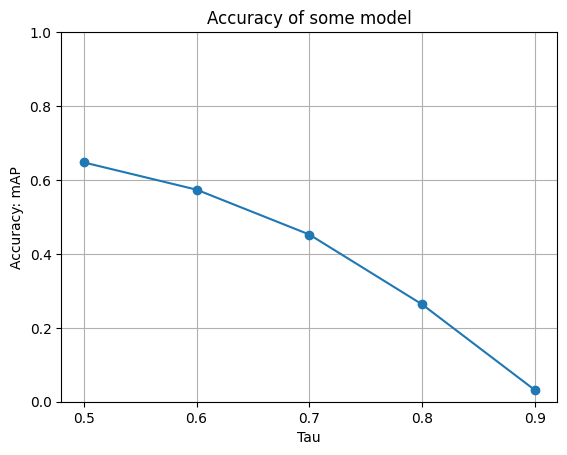

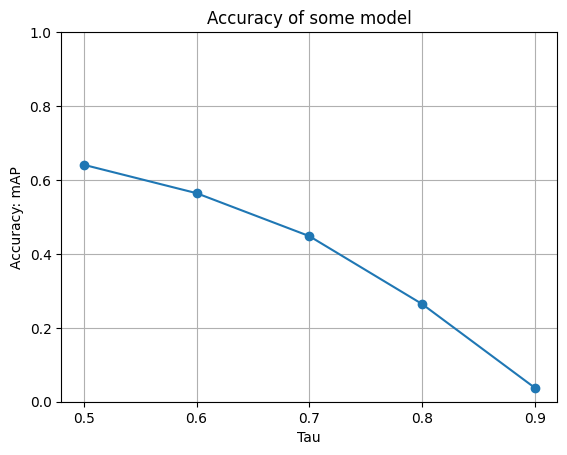

In [63]:
plt.plot(taus, model_mAPs[1], marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Tau')
plt.ylabel('Accuracy: mAP')
plt.title('Accuracy of some model')
plt.xticks(taus)
plt.ylim(0, 1)
plt.grid('on')

# Display the plot
plt.show()

plt.plot(taus, model_mAPs[2], marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Tau')
plt.ylabel('Accuracy: mAP')
plt.title('Accuracy of some model')
plt.xticks(taus)
plt.ylim(0, 1)
plt.grid('on')

# Display the plot
plt.show()